# **Deep Generative Model for spectral image synthesis**
* 2180034 - Brayan Esneider Monroy Chaparro
* 2180045 - Geison Alfredo Blanco Rodriguez
* 2180018 - Iván David Ortiz Pineda

## Contextualización del problema
Las **imágenes espectrales** contienen la información espacial y espectral de una escena. Esta información espectral resulta muy útil en áreas como, censado remoto, medicina y agricultura. 

<center><img src="https://www.spaceflightinsider.com/wp-content/uploads/2014/09/phoenix-img-2.jpg" width="50%"></center>


**Justificación del problema:**

Recientemente el Deep learning se ha incorporado entre las técnicas más prometedoras a la hora de resolver tareas de clasificación, segmentación, reconstrucción de imágenes espectrales. Sin embargo, como bien se sabe, la piedra angular del Deep learning son los datos, los cuales escasean y adicionalmente, la naturaleza de estas imágenes resulta ser de alta dimensionalidad lo cual aumenta la complejidad computacional a la hora de resolver las tareas mencionadas. 

Por consiguiente, para abordar ambas limitaciones en este trabajo se propone aprender una representación de baja dimensionalidad junto con un modelo generativo orientado a la síntesis de nuevas imágenes espectrales, permitiéndonos resolver los problemas sobre la representación de baja dimensionalidad y a su vez generar nuevos conjuntos de datos.

**Solución propuesta:**

Un enfoque tradicional para la generación de imágenes haría uso de cierta arquitectura de red GAN (generative adversal network), en donde ingresando cierto target a la red generadora esta crearía la imagen espectral correspondiente y a través del discriminador se haría la validación sobre que tan real fue la imagen generada. Así durante el entrenamiento se buscaría aumentar la capacidad del generador para sintetizar imágenes reales.

<center><img src="https://i.ibb.co/0VLnLzX/trad-1.png" width="60%"></center>

El **enfoque propuesto** en este trabajo consiste en el uso de una metodología en dos partes:
* Primero, se plantea el uso de una arquitectura de red autoencoder para aprender una representación no lineal de las imágenes espectrales, a la vez que se empleará un discriminador para aprender a diferenciar las imágenes reales y falsas con el fin de mejorar la fiabilidad del autoencoder.

<center><img src="https://i.ibb.co/tYYbPnM/architecture-1.png" width="80%"></center>

* Segundo, se plantea la implementación de un algoritmo de optimización siguiendo una arquitectura de ADMM para, con los pesos previamente entrenados, poder realizar la síntesis de imágenes espectrales partiendo de imágenes a escala de grises. En esta etapa se busca específicamente el aprendizaje de la representación de baja dimensionalidad $\alpha$ que mejor describe la imagen espectral.

<center><img src="https://i.ibb.co/TBDRc41/admm-1.png" width="60%"></center>

## Entrenamiento de la red utilizada

In [1]:
#@title **Código:** conexión con el drive
from google.colab import drive
drive.mount('/content/drive')
import os
import sys
os.chdir('/content/drive/My Drive/ProyectoIA2/generative-spectral-datasets')

Mounted at /content/drive


In [2]:
#@title **Código:** importando librerías

import tensorflow as tf
import numpy as np
from models.main import make_encoder, make_generator, make_discriminator, spectralGAN
from models.utils import discriminator_loss, autoencoder_loss, spec2rgb, get_RGB_matrix
from models.metrics import PSNR, SSIM
from data import load_dataset
import scipy.io as sio
import matplotlib.pyplot as plt

input_shape = (512,512,31)

In [3]:
#@title **Código:** cargando el dataset

BATCH_SIZE = 3

train_params = dict(
    batch_size = BATCH_SIZE,
    shuffle = True,
    cache = True
)

test_params = dict(
    batch_size = BATCH_SIZE,
    cache = True
)

train_ds , test_ds = load_dataset( train_params = train_params, test_params = test_params)

In [4]:
start , stop, bands = 400, 700 , 31
RGB = get_RGB_matrix(start, stop, bands)

minimo -0.009952549
maximo 0.8489122


 tf.Tensor([0.00613327 0.00638245 0.01418506], shape=(3,), dtype=float32)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


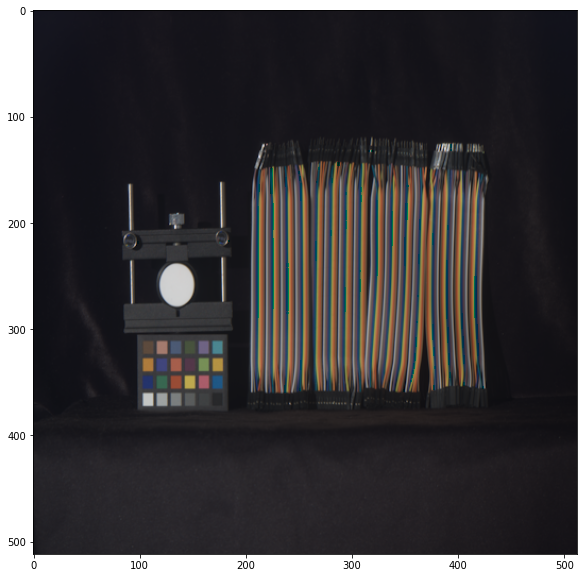

In [5]:
sample = next(iter(train_ds))
im = np.expand_dims(sample[0,...], axis = 0)

rgb = spec2rgb(im, RGB)
print( "minimo",np.min(rgb))
print( "maximo",np.max(rgb))

plt.figure(figsize=(10,10))
plt.imshow(np.power(rgb[0,:,:,:], 0.5))
print('\n\n',rgb[0, 0,0])

In [6]:
#@title **Código:** definiendo el optimizador y arquitectura de la red

a_optimizer = tf.keras.optimizers.Adam(1e-3)
d_optimizer = tf.keras.optimizers.Adam(1e-6)

FACTOR = [ 1/8 , 1/8 , 1/4 , 1/2 , 1/2, 1]
features= 64

encoded_shape = input_shape[:-1] + (3,)

encoder = make_encoder(encoded_shape, features=features, factors=FACTOR)
generator = make_generator(input_shape, features=features, factors=FACTOR)
discriminator = make_discriminator(input_shape)

In [7]:
#@title **Código:** mostrando la arquitectura de las redes

encoder.summary()
generator.summary()
discriminator.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
encoder (Encoder)            (None, 512, 512, 64)      23120     
Total params: 23,120
Trainable params: 23,120
Non-trainable params: 0
_________________________________________________________________
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 64)]    0         
_________________________________________________________________
generator (Generator)        (None, 512, 512, 31)      24398     
Total params: 24,398
Trainable params: 24,398
Non-trainable params: 0
_________________________________________________________________
Model: "discriminator"
_________

<center><img src="https://www.researchgate.net/profile/Gozde-Unal-2/publication/323904616/figure/fig1/AS:606457334595585@1521602104652/PatchGAN-discriminator-Each-value-of-the-output-matrix-represents-the-probability-of.png" width="55%"></center>

In [8]:
#@title **Código:** definiendo la arquitectura

from tensorflow.keras.callbacks import ModelCheckpoint

model = spectralGAN(encoder=encoder, generator=generator, discriminator=discriminator, CMF=RGB)

model.compile(
    a_optimizer = a_optimizer,
    d_optimizer = d_optimizer,
    a_loss = autoencoder_loss(tau=1e-3),
    d_loss = discriminator_loss,
    metrics = [ PSNR() ]
)


callbacks = [
             ModelCheckpoint( 'brayan_spectralGAN_rgb.h5', monitor='val_psnr',  verbose=1,  save_best_only=True,  save_weights_only=True,  mode="max", )
]


In [ ]:
_input = np.zeros(input_shape)[None,:]

_ = model.__call__(_input)
# model.load_weights('spectralGAN.h5')

In [ ]:
#@title **Código:** entrenando el modelo
history = model.fit(train_ds, epochs=10, validation_data=test_ds, callbacks=callbacks)

In [ ]:
#@title **Código:** guardando los pesos
# model.save_weights('spectralGAN.h5')

In [ ]:
#@title **Código:** mostrando la arquitectura general
model.summary()

In [ ]:
print(len(history.history["a_loss"]))
plt.plot(history.history["a_loss"])
plt.show()

plt.plot(history.history["d_loss"])
plt.show()

plt.plot(history.history["psnr"])
plt.show()

plt.plot(history.history["real_acc"])
plt.show()

plt.plot(history.history["fake_acc"])
plt.show()

print(history.history["psnr"][-1])
print(history.history.keys())

In [ ]:
#@title **Código:** mostrando una imágen generada

#@title **Código:** mostrando una imágen generada

sample = next(iter(train_ds)).numpy()

_input = spec2rgb(sample, RGB)

generated = model.autoencoder.predict(_input)
num = 0
RGB2 = [ 24, 15 , 5]

x_true = np.power( sample, 0.5 )
x_pred = np.power( generated, 0.5 )

plt.imshow(x_true[num][:,:,RGB2])
plt.show()

plt.imshow(x_pred[num][:,:,RGB2])
plt.show()

print(np.max(x_pred[num]))
print(np.min(x_pred[num]))

